<a href="https://colab.research.google.com/github/kim-slava/SII_7semestr/blob/main/SII_lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Материалы к курсовой работе.**

Пример обучении, оценке и валидации моделей, подборе оптимальных гиперпараметров. Мы будем решать задачу бинарной классификации, а именно, построим алгоритм, определяющий, превысит ли средний заработок человека порог $50000 в год.

В качестве метрики используется метрика ROC-AUC.

**Загрузка и обработка набора данных**
Загрузим набор данных из интернета с помощью функции pd.read_csv. Разделим данные на численные и категориальные, удалим из набора строчки с пропущенными значениями.

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv('/content/ObesityDataSet.csv')
# Назначаем имена колонок
# columns = ('age workclass fnlwgt education educ-num marital-status occupation relationship '
#            'race sex capital-gain capital-loss  hours-per-week native-country salary')

numeric_indices = np.array([1, 2, 3, 6, 7, 10, 12, 13])
categorical_indices = np.array([0, 4, 5, 8, 9, 11, 14, 15])

# df.columns = columns.split() #этот метод разделит датасет по колонкам, как в массиве columns

# df = df.replace('?', np.nan)

df = df.dropna()

# df['salary'] = df['salary'].apply((lambda x: x==' >50K')) # Будем предсказывать 1 (True), если зарплата больше 50K, 0 (False) иначе
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [ ]:
numeric_data = df[df.columns[numeric_indices]]

categorial_data = df[df.columns[categorical_indices]]
categorial_data.head()
# numeric_data.head()

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS
0,Female,yes,no,Sometimes,no,no,no,Public_Transportation
1,Female,yes,no,Sometimes,yes,yes,Sometimes,Public_Transportation
2,Male,yes,no,Sometimes,no,no,Frequently,Public_Transportation
3,Male,no,no,Sometimes,no,no,Frequently,Walking
4,Male,no,no,Sometimes,no,no,Sometimes,Public_Transportation


In [ ]:
df.NObeyesdad.unique()

array(['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II',
       'Obesity_Type_I', 'Insufficient_Weight', 'Obesity_Type_II',
       'Obesity_Type_III'], dtype=object)

NObesity values are:

Underweight Less than 18.5

Normal 18.5 to 24.9

Overweight 25.0 to 29.9

Obesity I 30.0 to 34.9

Obesity II 35.0 to 39.9

Obesity III Higher than 40

In [ ]:
df.NObeyesdad.replace({
'Insufficient_Weight':0,
'Normal_Weight':0,
'Overweight_Level_I':0,
'Overweight_Level_II':0,
'Obesity_Type_I':1,
'Obesity_Type_II':1,
'Obesity_Type_III':1}, inplace=True)

df.NObeyesdad

0       0
1       0
2       0
3       0
4       0
       ..
2106    1
2107    1
2108    1
2109    1
2110    1
Name: NObeyesdad, Length: 2111, dtype: int64

In [ ]:
y = df['NObeyesdad']
y.mean()

0.4604452865940313

**One-hot кодирование**

Поскольку алгоритмы машинного обучения, работают лишь с числовыми признаками, необходимо придумать способ обработки категориальных признаков, переводящий их в числовые. Одним из способов сделать это является One-hot кодирование. Его суть состоит в следующем. Пусть некоторая категориальная переменная (скажем, color) принимает  n  различных значений (Red, Yellow, Green). Тогда можно создать  n  новыx переменныx, соответствующих различным значениям категориального признака, каждая из которых равна 1 в том случае, если изначальный категориальный признак принимает такое значение, и 0 иначе. Принцип работы иллюстрирован на картинке.
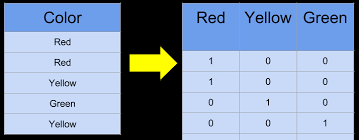
В Pandas One-hot кодирование выполняется функцией pd.get_dummies. Сгенерируем One-hot признаки для нашего датасета. Сохраним полную матрицу объекты признаки в переменную X.

In [ ]:
dummy_features = pd.get_dummies(categorial_data)
X = pd.concat([numeric_data, dummy_features], axis=1)
X.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,Gender_Male,...,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,21.0,1.62,64.0,2.0,3.0,2.0,0.0,1.0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,21.0,1.52,56.0,3.0,3.0,3.0,3.0,0.0,1,0,...,1,0,0,1,0,0,0,0,1,0
2,23.0,1.80,77.0,2.0,3.0,2.0,2.0,1.0,0,1,...,0,0,1,0,0,0,0,0,1,0
3,27.0,1.80,87.0,3.0,3.0,2.0,2.0,0.0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,22.0,1.78,89.8,2.0,1.0,2.0,0.0,0.0,0,1,...,0,0,0,1,0,0,0,0,1,0


In [ ]:

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 2111 non-null   float64
 1   Height                              2111 non-null   float64
 2   Weight                              2111 non-null   float64
 3   FCVC                                2111 non-null   float64
 4   NCP                                 2111 non-null   float64
 5   CH2O                                2111 non-null   float64
 6   FAF                                 2111 non-null   float64
 7   TUE                                 2111 non-null   float64
 8   Gender_Female                       2111 non-null   uint8  
 9   Gender_Male                         2111 non-null   uint8  
 10  family_history_with_overweight_no   2111 non-null   uint8  
 11  family_history_with_overweight_yes  2111 no

In [ ]:
X=X.drop(['Gender_Female','family_history_with_overweight_no','FAVC_no','SMOKE_no','SCC_no'],axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 26 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 2111 non-null   float64
 1   Height                              2111 non-null   float64
 2   Weight                              2111 non-null   float64
 3   FCVC                                2111 non-null   float64
 4   NCP                                 2111 non-null   float64
 5   CH2O                                2111 non-null   float64
 6   FAF                                 2111 non-null   float64
 7   TUE                                 2111 non-null   float64
 8   Gender_Male                         2111 non-null   uint8  
 9   family_history_with_overweight_yes  2111 non-null   uint8  
 10  FAVC_yes                            2111 non-null   uint8  
 11  CAEC_Always                         2111 no

Выделим целевую переменную в y и вычислим процент единиц в значениях y.

In [ ]:
y = df['NObeyesdad']
y.mean()

0.4604452865940313

**Разбиение данных на train и test**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, train_size=0.8)

**Нормировка данных**

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Логистическая регрессия**
Для логистической регрессии гиперпараметры как правило не так сильно влияют на результат. Запускаем её с параметрами по умолчанию.

Train roc-auc: 0.9999278649292016
Test roc-auc: 0.9981175205055802


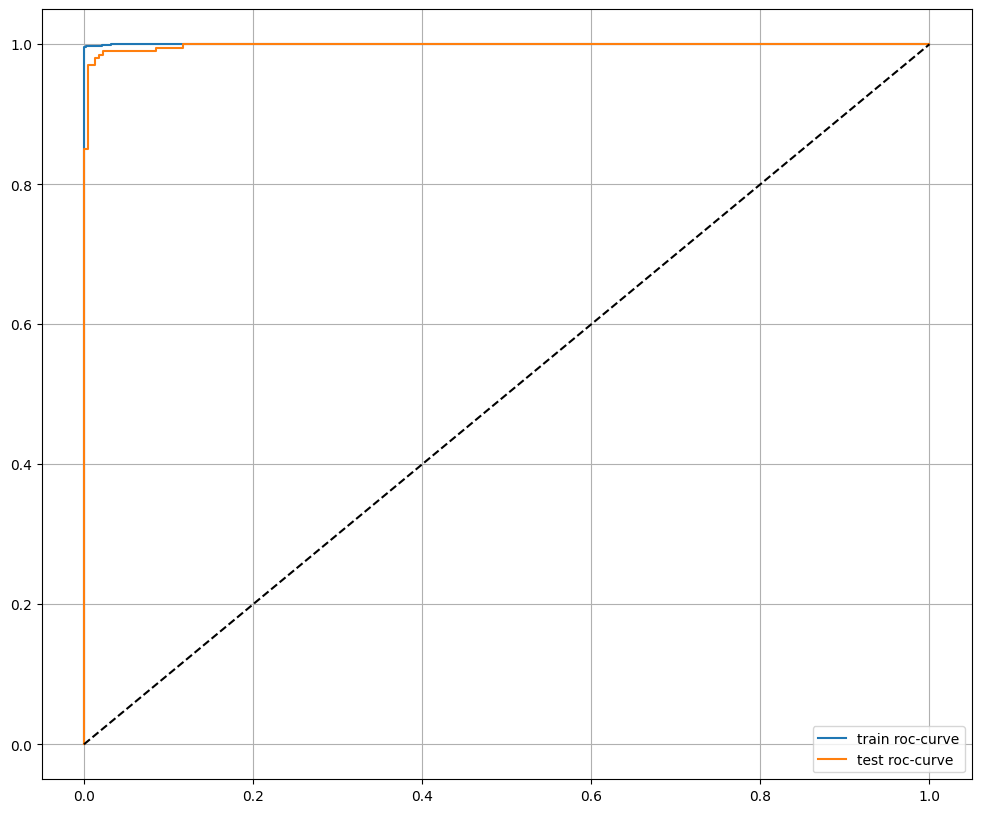

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(model, X_train, X_test, y_train, y_test):
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    plt.figure(figsize=(12,10))
    print(f'Train roc-auc: {roc_auc_score(y_train, y_train_proba)}')
    print(f'Test roc-auc: {roc_auc_score(y_test, y_test_proba)}')


    plt.plot(*roc_curve(y_train, y_train_proba)[:2], label='train roc-curve')
    plt.plot(*roc_curve(y_test, y_test_proba)[:2], label='test roc-curve')

    plt.plot([0,1], [0,1], linestyle='--', color='black')
    plt.grid(True)
    plt.legend()
    plt.show()

from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(X_train, y_train)
plot_roc_curve(model, X_train, X_test, y_train, y_test)

**Выбор модели, подбор гиперпараметра**
Для подбора оптимального гиперпараметра будем использовать перебор параметра по сетке. Качество будем измерять с помощью кросс-валидации.

Суть метода кросс-валидации схематично изображена на картинке.
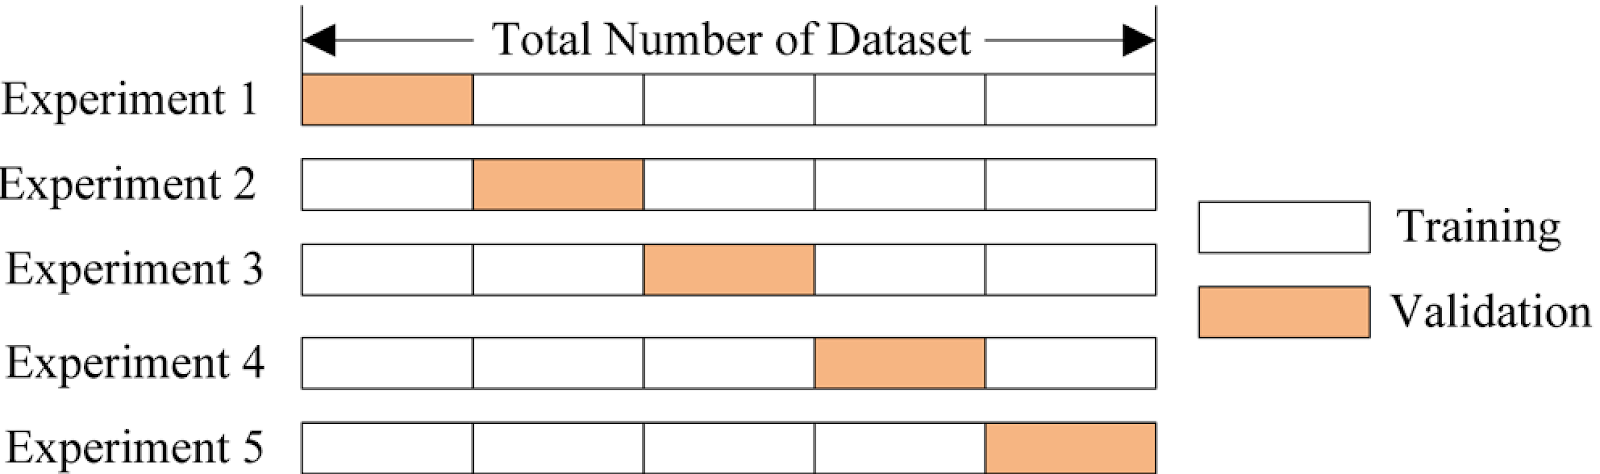
Напишем функцию, визуализирующую поиск оптимального гиперпараметра модели по сетке. Для этого используем метод GridSearchCV из sklearn.model_selection.

In [ ]:
from sklearn.model_selection import GridSearchCV

def search(X, y, model, param_name, grid, draw=True):
    parameters = {param_name: grid}

    CV_model = GridSearchCV(estimator=model, param_grid=parameters, cv=5, scoring='roc_auc', n_jobs=-1)
    CV_model.fit(X, y)
    means = CV_model.cv_results_['mean_test_score']
    error = CV_model.cv_results_['std_test_score']

    if draw:
        plt.figure(figsize=(15,8))
        plt.title('choose ' + param_name)


        plt.plot(grid, means, label='mean values of score')

        plt.fill_between(grid, means - 2 * error, means + 2 * error, color='green', label='deviation area between errors')
        plt.legend()
        plt.xlabel('parameter')
        plt.ylabel('roc_auc')
        plt.show()

    return means, error

**Протестируем функцию на KNN и решающем дереве.**

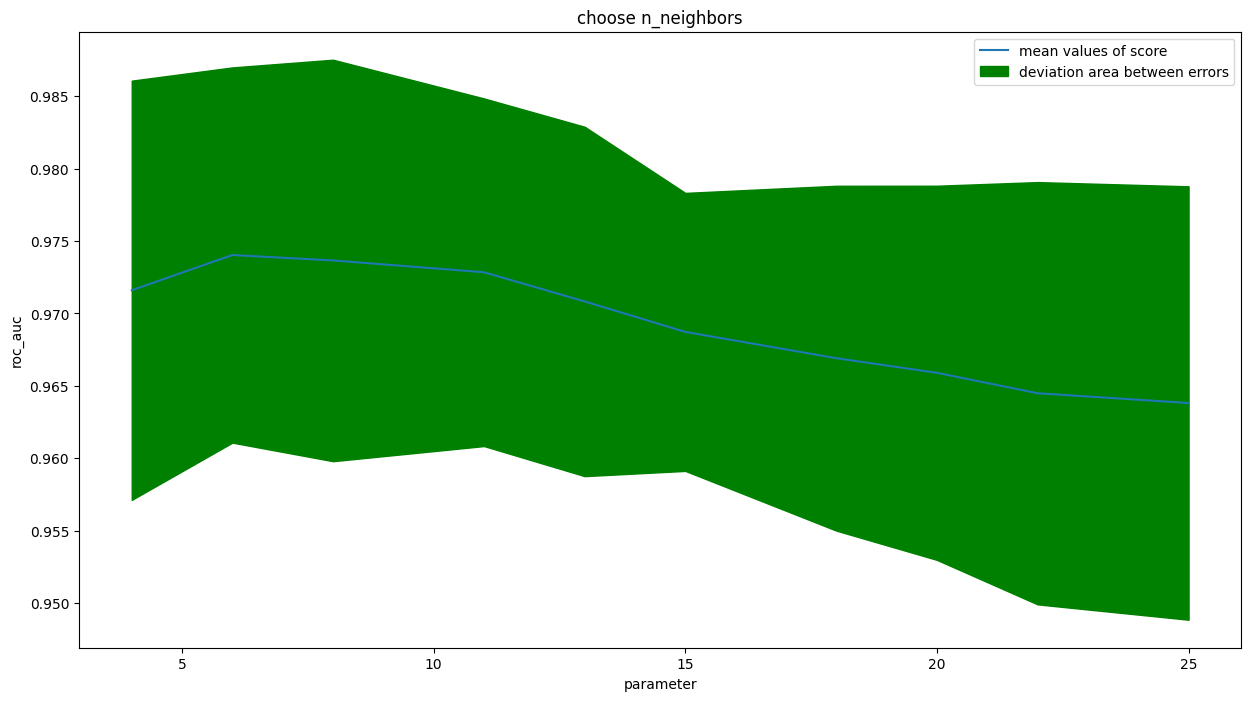

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

models = [KNeighborsClassifier(n_jobs=-1)]
param_names = ['n_neighbors']
grids = [np.array(np.linspace(4, 25, 10), dtype='int')]
param_scales = ['ordinary']

for model, param_name, grid, param_scale in zip(models,
                                                param_names,
                                                grids,
                                                param_scales):
    search(X_train, y_train, model, param_name, grid, param_scale)

Train roc-auc: 0.9731346365736124
Test roc-auc: 0.976581058670611


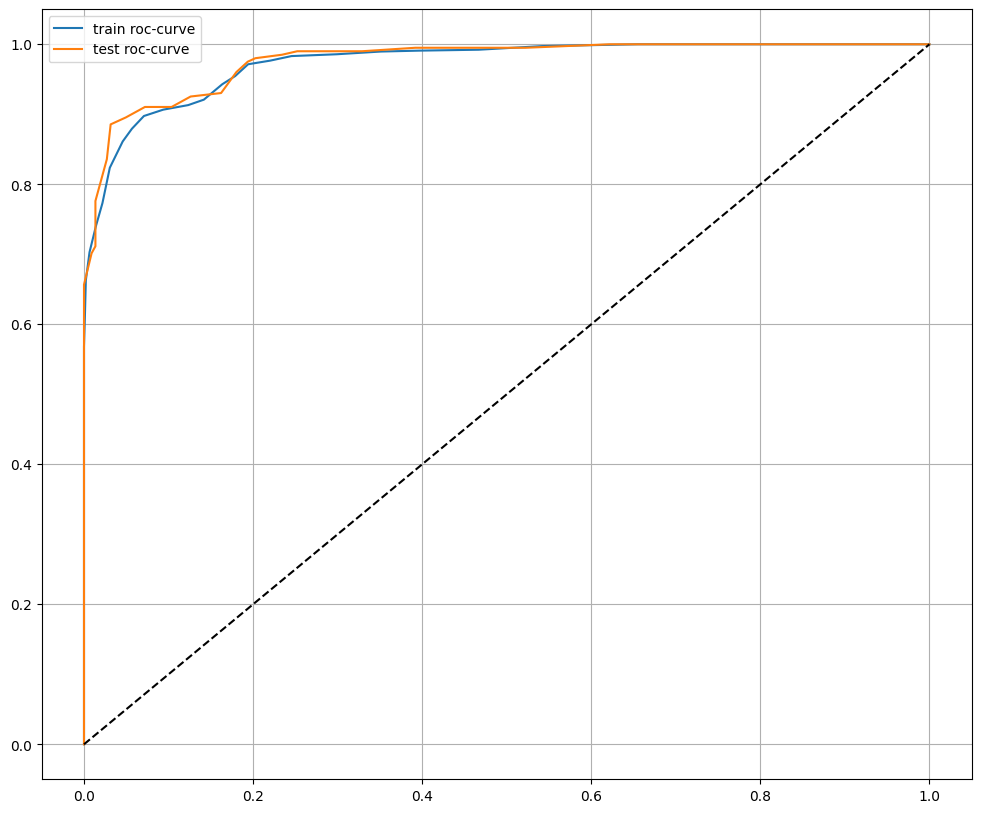

In [ ]:
model = KNeighborsClassifier(n_neighbors=25, n_jobs=-1).fit(X_train, y_train)
plot_roc_curve(model, X_train, X_test, y_train, y_test)

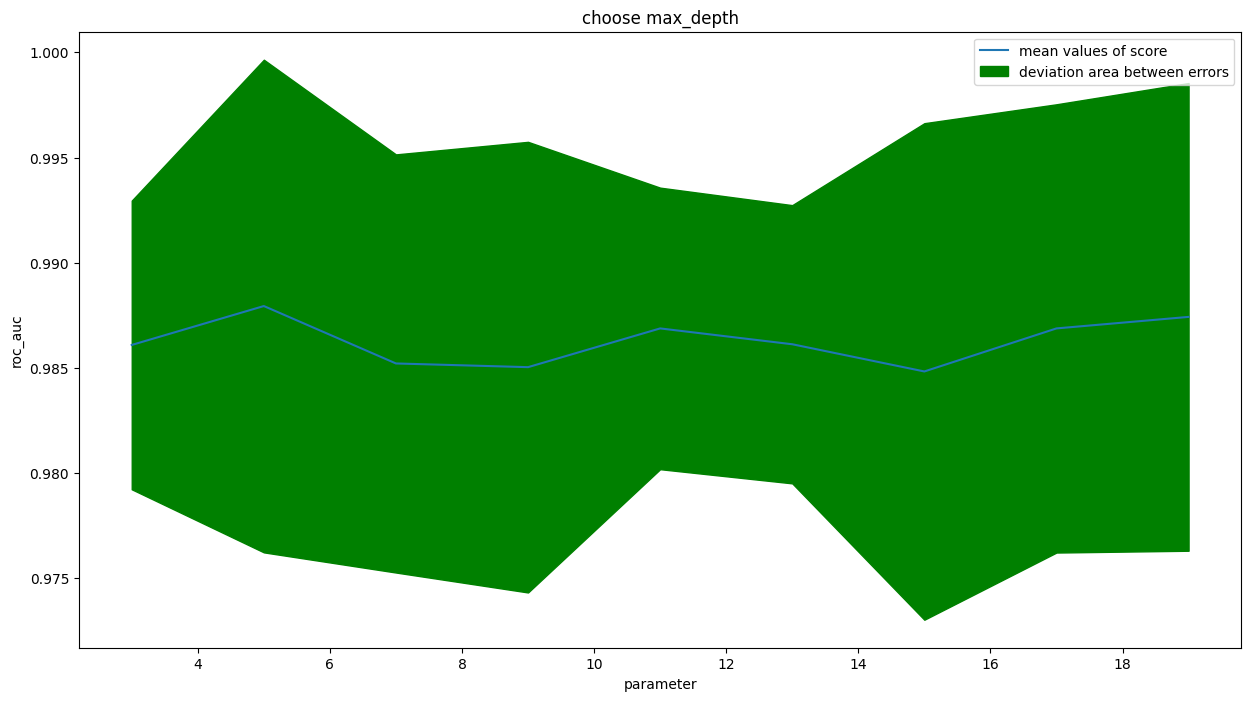

In [ ]:
models = [DecisionTreeClassifier()]
param_names = ['max_depth']
grids = [np.arange(3, 21, 2)]
param_scales = ['ordinary']

for model, param_name, grid, param_scale in zip(models,
                                                param_names,
                                                grids,
                                                param_scales):
    search(X_train, y_train, model, param_name, grid, param_scale)

Train roc-auc: 0.9999257433094723
Test roc-auc: 0.9896463627806912


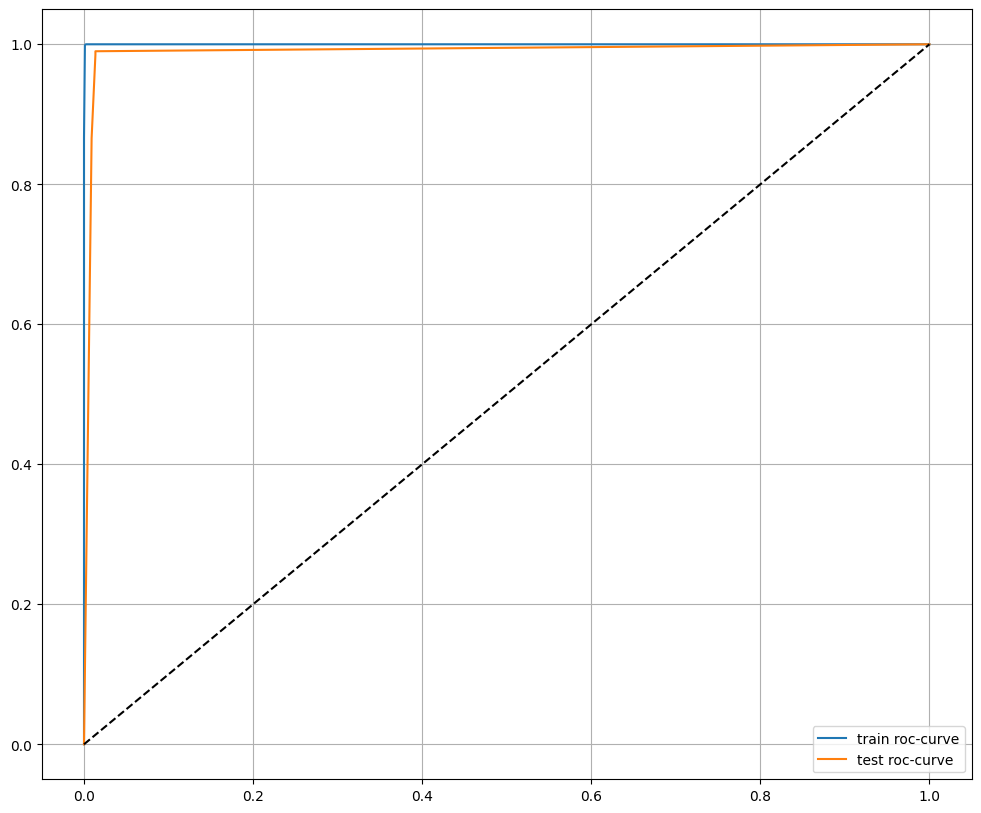

In [ ]:
model = DecisionTreeClassifier(max_depth=7).fit(X_train, y_train)
plot_roc_curve(model, X_train, X_test, y_train, y_test)

**Случайный лес**
Подберём параметр n_estimators в алгоритме случайный лес. Известно, что случайный лес не переобучается. Поэтому график качества будет монотонно возрастать. Следовательно, необходимо найти минимальное значение n_estimators, при котором качество не изменяется. Поскольку каждое дерево обучается независимо от остальных, достаточно обучить сразу лес из большого количества деревьев, а затем рассмотреть подмножества нужного размера из исходного множества деревьев.


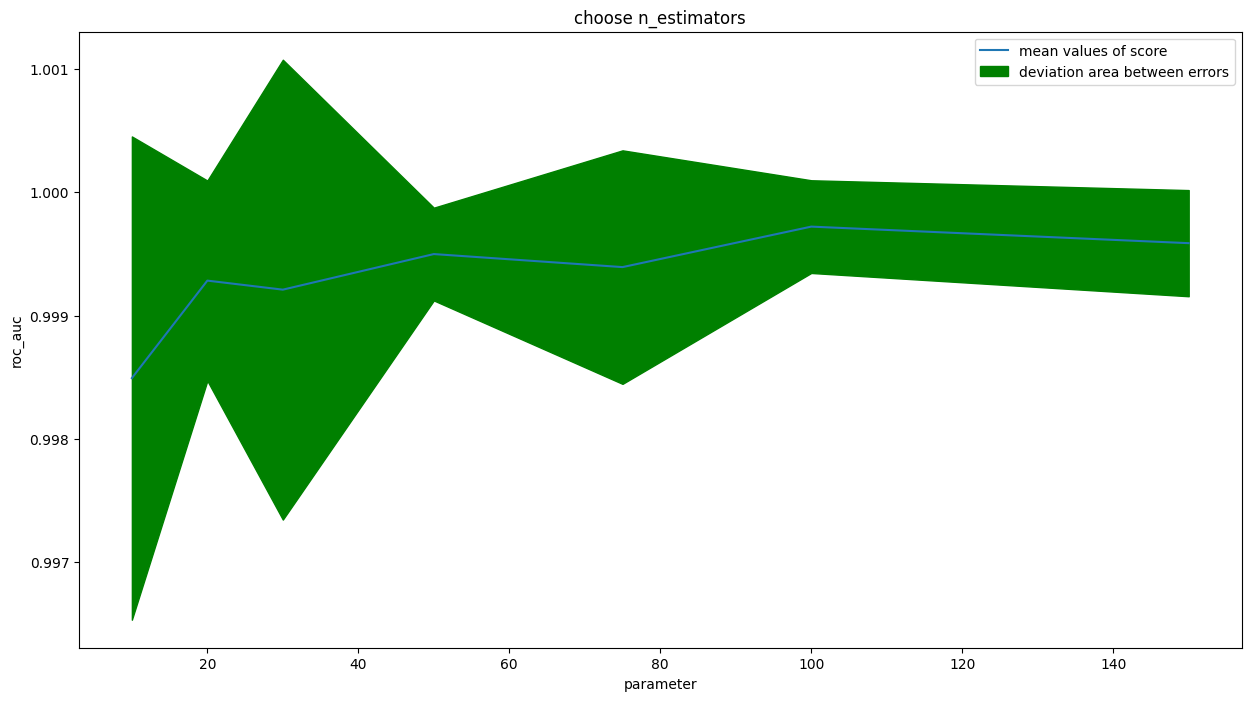

In [ ]:
from sklearn.ensemble import RandomForestClassifier

models = [RandomForestClassifier(n_jobs=-1)]
param_names = ['n_estimators']
grids = [[10, 20, 30, 50, 75, 100, 150]]
param_scales = ['ordinary']

for model, param_name, grid, param_scale in zip(models,
                                                param_names,
                                                grids,
                                                param_scales):
    search(X_train, y_train, model, param_name, grid, param_scale)

Train roc-auc: 1.0
Test roc-auc: 0.999798305768455


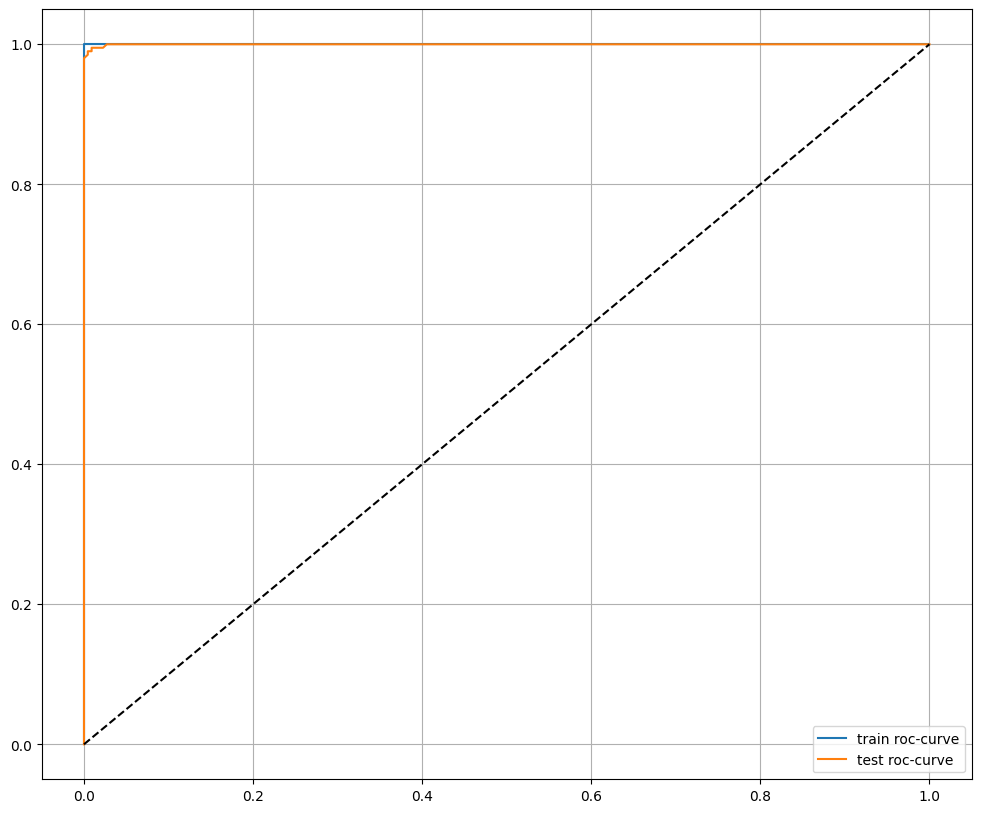

In [ ]:
model = RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(X_train, y_train)
plot_roc_curve(model, X_train, X_test, y_train, y_test)

**Что ещё можно делать.**

Искать по сетке не только численные гиперпараметры, но и категориальные, например, метрику в алгоритме ближайших соседей или критерий ветвления в решающем дереве.

Искать оптимальный параметр по многомерной сетке. Перебрать все возможные варианты здесь не выйдет, потому что на это уйдёт слишком много времени. Зато можно перебирать случайные точки по сетке. Эта процедура называется Grid Random Search.

**Бустинг**
Подберём параметр max_depth для градиентного бустинга

In [ ]:
import xgboost

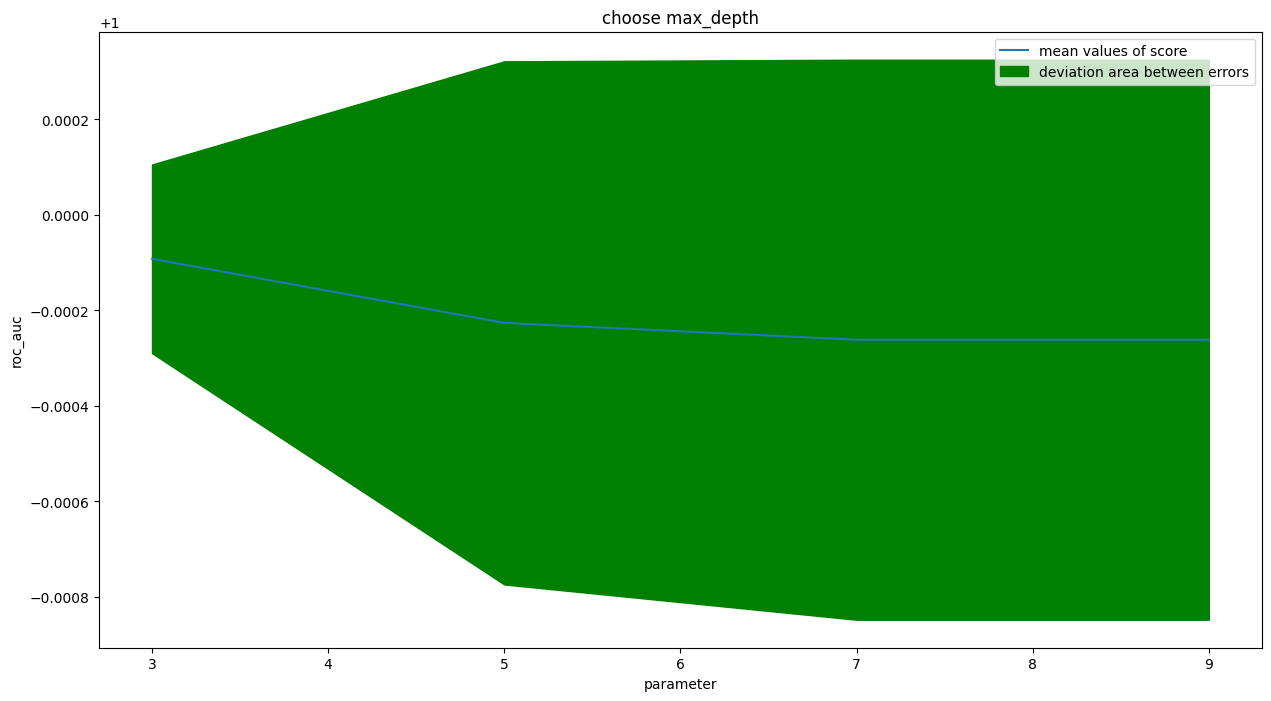

In [ ]:
models = [xgboost.XGBClassifier(n_estimators=200)]
param_names = ['max_depth']
grids = [np.arange(3,10,2)]
param_scales = ['ordinary']

for model, param_name, grid, param_scale in zip(models,
                                                param_names,
                                                grids,
                                                param_scales):
    search(X_train, y_train, model, param_name, grid, param_scale)

Train roc-auc: 1.0
Test roc-auc: 0.9999775895298284


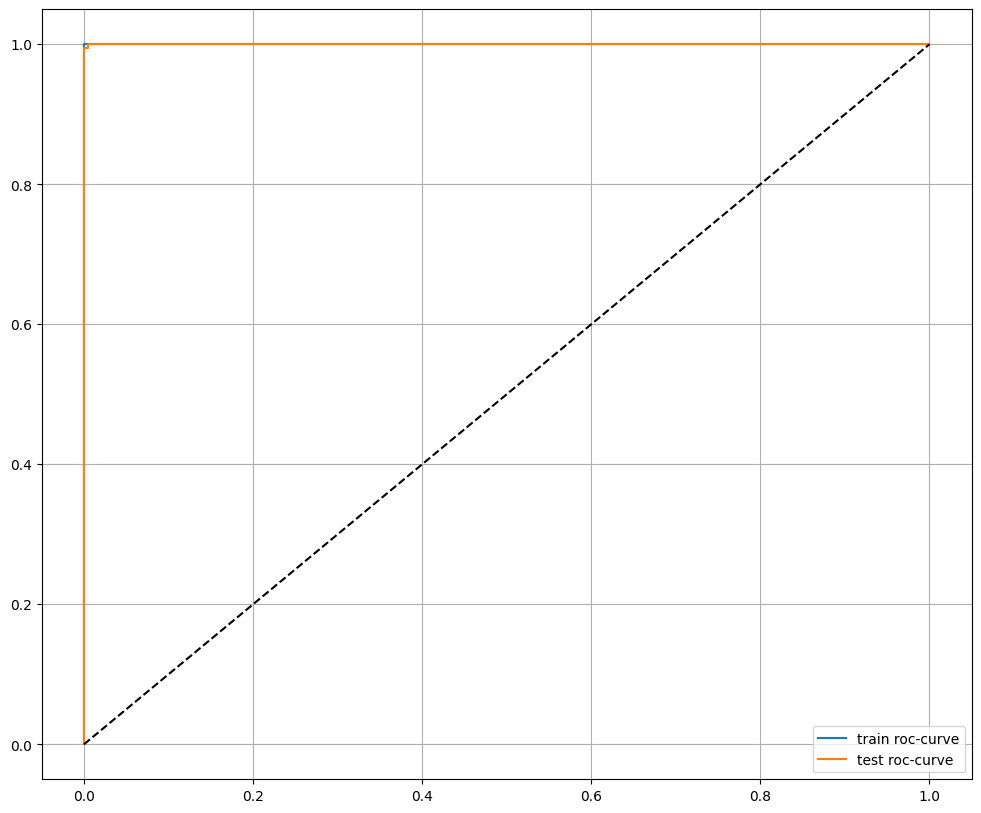

In [ ]:
model = xgboost.XGBClassifier(max_depth=5, n_estimators=300).fit(X_train, y_train)
plot_roc_curve(model, X_train, X_test, y_train, y_test)

Train roc-auc: 0.9257963499654175
Test roc-auc: 0.9604567253820986


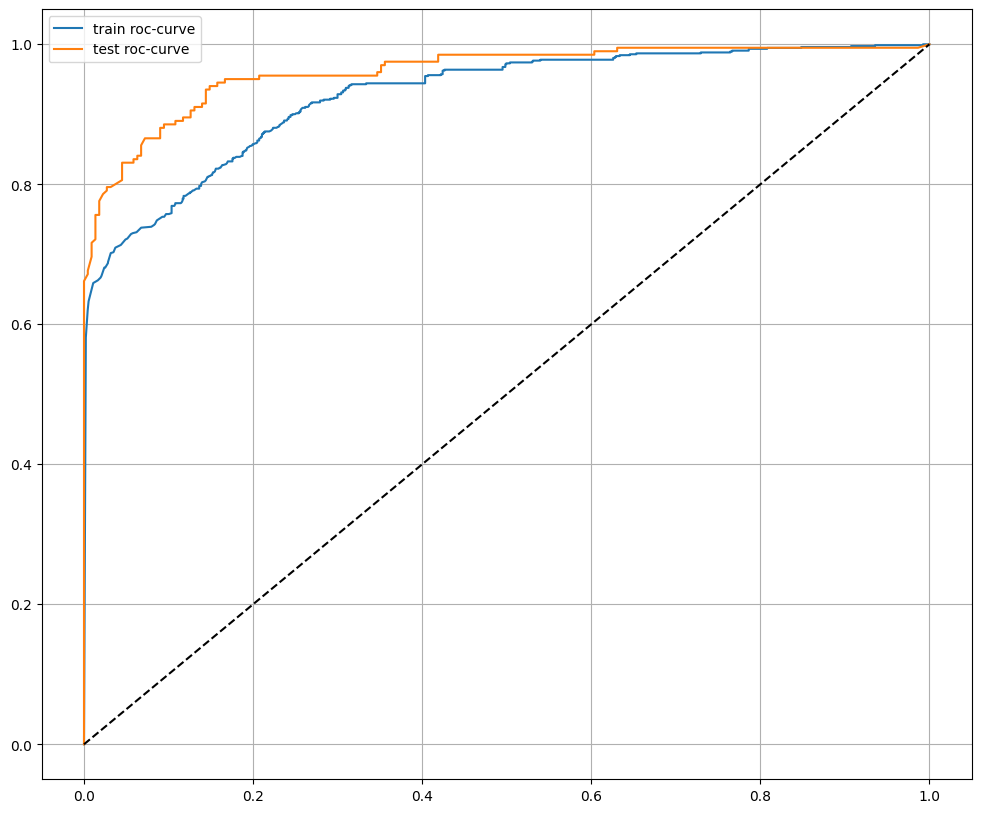

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB().fit(X_train, y_train)
plot_roc_curve(model, X_train, X_test, y_train, y_test)



                                                    train                   test
Логистическая регрессия     ----------------------    0.9999278649292016   -------- 0.9999278649292016

---

KNN -----------------------------------------------------------0.9731346365736124 -------- 0.976581058670611

---

решающее дерево ---------------------------------- 0.9999257433094723
-------- 0.9896463627806912

---

Случайный лес ------------------------------------------------------- 1.0
----------------------- 0.999798305768455

---

БустингTrain ----------------------------------------------------------- 1.0
----------------------- 0.9999775895298284

---

Наивный Байесовский классификатор - 0.9257963499654175
-------- 0.9604567253820986